**ANOVA Correlation**
- Filter method
- Assumes liner relationship between the feature and the target variable (!)
- Selects the top k features that have the highest correlation to the target variable

**Variance Filtering**
- Filter method
- Removes features with low variance
- might be on different scales(!!!)
- (could be each omics data individually)
    
**Mutual Information based Feature Selection (MIFS)**
- Measures how much information the presence/absence of a feature contributes to making the correct prediction on Y
- Can capture nonlinear relationships between features and the target variable
- [MIFS-ND: A mutual information-based feature selection method](https://www.sciencedirect.com/science/article/pii/S0957417414002164#:~:text=A%20mutual%20information%2Dbased%20feature%20selection%20algorithm%20called%20MIFS%20is,mutual%20information%20for%20feature%20selection)

Individually!!!
all the omics datasets must be represented
### TODO
**RelieF** (Especially this, it's mentioned in every paper)
**Fast Correlated Based Filter**
**Measure REDUNDANCY** (Using mutual information)   


**Recursive Feature Elimination (RFE)**
- Wrapper approach to feature selection
- There are many algorithms that can choose the best features
- Starts with all features and removes the least important one at each iteration

num features
speed of the model



interpretability
- has the found feature already been studied with Alzheimer's disease?
similarity network fusion, (was god for prediction)
mixOmics package (kkeping datasets seperate) -> data integration
- multi block approach
- diablo pls-da multi block vs pls-da with concatenated comparison
check proportion of features that comes out (we want to have all the data types)
PCA just visualization (if there are big disprepancies more processing is needed!)
loadings plots (color each point by the type of omics data)
scores plot look for outliers

feature selection 2 steps (which needed - both ? first? second? why)
make a pipeline, build exact same models, evaluate feature selection steps
why baseline selection (have to motivate)
to slow, noise, overfitting -> less interpretable selection
num of features????

guild.ai - track results of different experiments (very cool!)
optuna - optimizing hyperparams

correlated features - might be problem for SHAP (but we loose on interpretation - might put them back)

### Questions
- Categorical features in the dataset
- How to evaluate the performance of the feature selection methods?
(I cannot just evaluate all of them on some ML model since it might favour different features)
- Explainability
- When to perform Pathway Analysis?
- How to assess number of features to select?
**(Plot Performance vs. Number of Features)**

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load data
# path = "C:/Users/mjgoj/Desktop/THESIS/data/OMICS_data.csv"
path = "C:/Users/mjgoj/Desktop/THESIS/data/OMICS_data_updated.csv"
# Load the dataset
data = pd.read_csv(path)

Y = data[['ThreeClass']]
# Change the shape of y to (n_samples, )
Y = np.ravel(Y)

X = data.drop(['TwoClass'], axis=1)
print("Initial shape of X: ", X.shape)

Initial shape of X:  (96, 1123)


In [3]:
# Find the categorical features
"""
TAG_LOW_GLUCOSE
TAG_HIGH_PYRUVATE
TAG_HIGH_LACTATE
TAG_UNEXPECTED_AMINO_ACID_SIGNALS
TAG_LOW_GLUTAMINE_HIGH_GLUTAMATE
TAG_LOW_PROTEIN_CONTENT
TAG_PLASMA_SAMPLE
TAG_HIGH_ETHANOL
"""
# get values for each categorical feature
#print(X['Feature update_stamp.x'])
print(X['TAG_HIGH_ETHANOL'])

0     0
1     0
2     0
3     0
4     0
     ..
91    0
92    0
93    0
94    0
95    0
Name: TAG_HIGH_ETHANOL, Length: 96, dtype: int64


In [4]:
categorical = [col for col in X.columns if X[col].nunique() < 3]
print("Categorical features: ", categorical)

# Remove the categorical features
X = X.drop(categorical, axis=1)

Categorical features:  ['TAG_LOW_GLUCOSE', 'TAG_HIGH_PYRUVATE', 'TAG_HIGH_LACTATE', 'TAG_UNEXPECTED_AMINO_ACID_SIGNALS', 'TAG_LOW_GLUTAMINE_HIGH_GLUTAMATE', 'TAG_LOW_PROTEIN_CONTENT', 'TAG_PLASMA_SAMPLE', 'TAG_HIGH_ETHANOL']


In [5]:
print(type(Y))

<class 'numpy.ndarray'>


In [6]:
def venn_diagram(set_lists, set_labels):
    """
    Create a Venn diagram for 2 or 3 sets
    :param set_lists: list of sets of features
    :param set_labels: list of the filtering methods used
    """
    if len(set_lists) == 2:
        venn2(set_lists, set_labels)
    elif len(set_lists) == 3:
        venn3(set_lists, set_labels)
    plt.show()

In [7]:
def ANOVA_correlation_filtering(k, X_, Y_):
    """
    ANOVA F-value statistics to select the top k features
    that have the highest correlation to the target variable
    :param k: the number of features to select
    :param X_: the feature matrix
    :param Y_: the class labels
    """
    selector = SelectKBest(f_classif, k=k)  # Selects the top 10 features
    X_new = selector.fit_transform(X_, Y_)
    print("Shape of X after ANOVA filtering: ", X_new.shape)
    # Return the names of the columns that were picked
    features = X.columns[selector.get_support()]
    return features

In [8]:
def variance_filtering(samples_percentage, X_):
    """
    Removing features with low variance
    :param samples_percentage: the percentage of samples that should have the same value for a feature to be removed
    :param X_: the feature matrix
    """
    sel = VarianceThreshold(threshold=(samples_percentage * (1 - samples_percentage)))
    X_ = sel.fit_transform(X_)
    print("Shape of X after variance filtering: ", X_.shape)
    # Return the names of the columns that were picked
    features = X.columns[sel.get_support()]
    return features

In [9]:
def mutual_information_filtering(k, X_, Y_):
    """
    Mutual Information based Feature Selection (MIFS)
    Mutual information statistics to select the top k features
    that have the highest correlation to the target variable
    
    Measures how much information the presence/absence of a feature 
    contributes to making the correct prediction on Y
    
    :param k: the number of features to select
    :param X_: the feature matrix
    :param Y_: the class labels
    """
    
    selector = SelectKBest(mutual_info_classif, k=k)
    X_new = selector.fit_transform(X_, Y_)
    print("Shape of X after mutual information filtering: ", X_new.shape)
    # Return the names of the columns that were picked
    features = X.columns[selector.get_support()]
    return features

In [10]:
def recursive_feature_elimination(k, X_, Y_, estimator=DecisionTreeClassifier()):
    """
    Wrapper approach to feature selection
    Starts with all features and removes the least important one at each iteration
    :param k: number of features to select
    :param X_: the feature matrix
    :param Y_: the class labels
    :param estimator: the model used to evaluate the importance of features
        DecisionTreeClassifier
        RandomForestClassifier
        
    """

    selector = RFE(estimator, n_features_to_select=k, step=1)
    X_new = selector.fit_transform(X_, Y_)
    print("Shape of X after RFE: ", X_new.shape)
    # Return the names of the columns that were picked
    features = X.columns[selector.get_support()]
    return features

In [11]:
all_features = set(X.columns)
variance_filtered_features = set(variance_filtering(0.75, X))
correlation_filtered_features = set(ANOVA_correlation_filtering(200, X, Y))

Shape of X after variance filtering:  (96, 671)
Shape of X after ANOVA filtering:  (96, 200)


C:\Users\mjgoj\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [12]:
mutual_info_filtered_features = set(mutual_information_filtering(200, X, Y))
recursive_filtered_features = set(recursive_feature_elimination(200, X, Y))

Shape of X after mutual information filtering:  (96, 200)
Shape of X after RFE:  (96, 200)


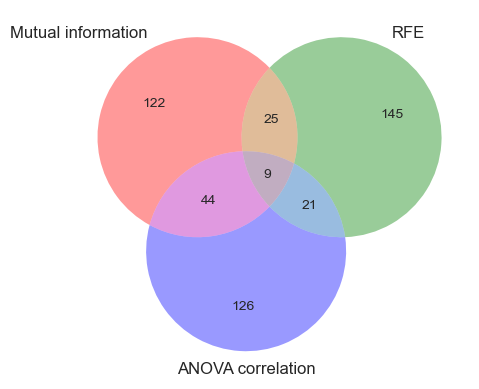

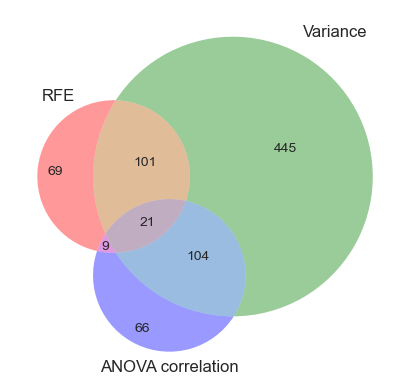

In [13]:
venn_diagram(
    [mutual_info_filtered_features, recursive_filtered_features, correlation_filtered_features],
    ("Mutual information", "RFE", "ANOVA correlation")
)

venn_diagram(
    [recursive_filtered_features, variance_filtered_features, correlation_filtered_features],
    ("RFE", "Variance", "ANOVA correlation")
)

In [14]:
%load_ext rpy2.ipython

C:\Users\mjgoj\miniconda3\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [15]:
# Conversion to R
variance = list(variance_filtered_features)
recursive = list(recursive_filtered_features)
mutual_info = list(mutual_info_filtered_features)
correlation = list(correlation_filtered_features)
all = list(all_features)

%R -i variance -i recursive -i mutual_info -i correlation -i all

[1] "#FBB4AE" "#B3CDE3" "#CCEBC5" "#DECBE4" "#FED9A6"


Loading required package: grid
Loading required package: futile.logger


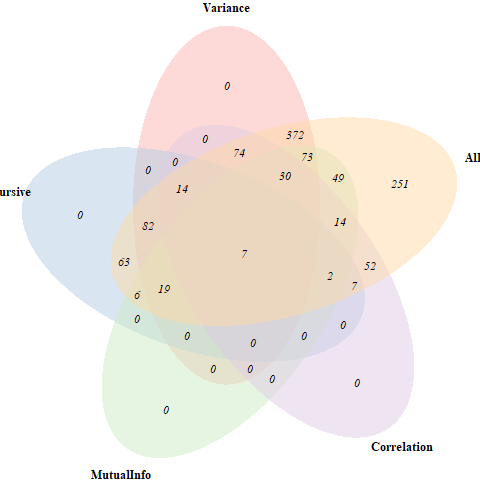

In [16]:
%%R -i variance -i recursive -i mutual_info -i correlation -i all
library(VennDiagram)

library(RColorBrewer)
colors <- brewer.pal(5, "Pastel1")
print(colors)

# Assuming 'variance', 'recursive', etc., are correctly passed as lists from Python
x <- list(
  Variance = variance,
  Recursive = recursive,
  MutualInfo = mutual_info,
  Correlation = correlation,
    All = all
)

# Generate and display the Venn diagram
# Note: For more than 3 sets, consider using alternative visualization techniques
venn.plot <- venn.diagram(
    x = x,
    filename = NULL,
    # Circles
    lwd = 1, lty = 'blank', fill = colors,
    compression = "lzw",
    resolution = 500,
    # Numbers
    cex = .9, fontface = "italic",
    # Labels
    cat.cex = 1, cat.fontface = "bold", cat.default.pos = "outer"

)

# Display the plot
grid.draw(venn.plot)
  